In [27]:

import torch
from torch import nn
import traintools


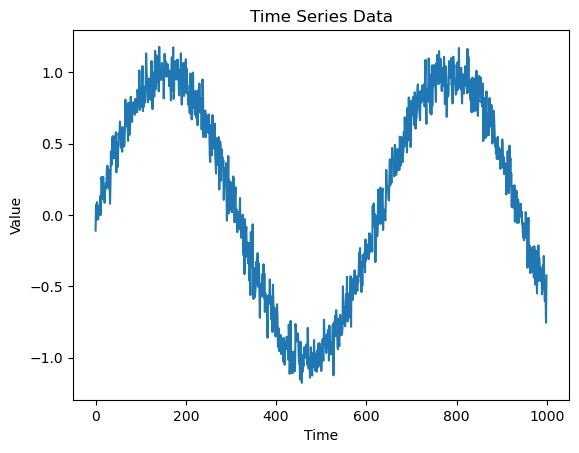

In [28]:
T = 1000
time = torch.arange(T,dtype=torch.float32)
x = torch.sin(time * 0.01) + torch.normal(0, 0.1, (T,), dtype=torch.float32)

# 绘制图像
import matplotlib.pyplot as plt
plt.plot(time, x)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()


In [29]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
	features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape(-1, 1)


In [30]:
batch_size ,n_train = 16, 1024
# 只有前 n_train 个样本用于训练
train_iter = traintools.load_array((features[:n_train], labels[:n_train]), batch_size,is_train=True)

def init_weights(m):
	if type(m) == nn.Linear:
		nn.init.xavier_uniform_(m.weight)

def get_net():
	net = nn.Sequential(
		nn.Linear(4,10),
		nn.ReLU(),
		nn.Linear(10,1)
	)
	net.apply(init_weights)
	return net

loss = nn.MSELoss()

def train(net,train_iter,loss,epochs,lr):
	trainer = torch.optim.Adam(net.parameters(), lr=lr)
	for epoch in range(epochs):
		for X,y in train_iter:
			trainer.zero_grad()
			y_hat = net(X)
			l = loss(y_hat, y)
			l.backward()
			trainer.step()
		print(f"Epoch {epoch + 1}, Loss: {l.item():.4f}")
net = get_net()
train(net, train_iter, loss, epochs=10, lr=0.01)

Epoch 1, Loss: 0.0110
Epoch 2, Loss: 0.0258
Epoch 3, Loss: 0.0025
Epoch 4, Loss: 0.0144
Epoch 5, Loss: 0.0246
Epoch 6, Loss: 0.0030
Epoch 7, Loss: 0.0279
Epoch 8, Loss: 0.0044
Epoch 9, Loss: 0.0033
Epoch 10, Loss: 0.0127


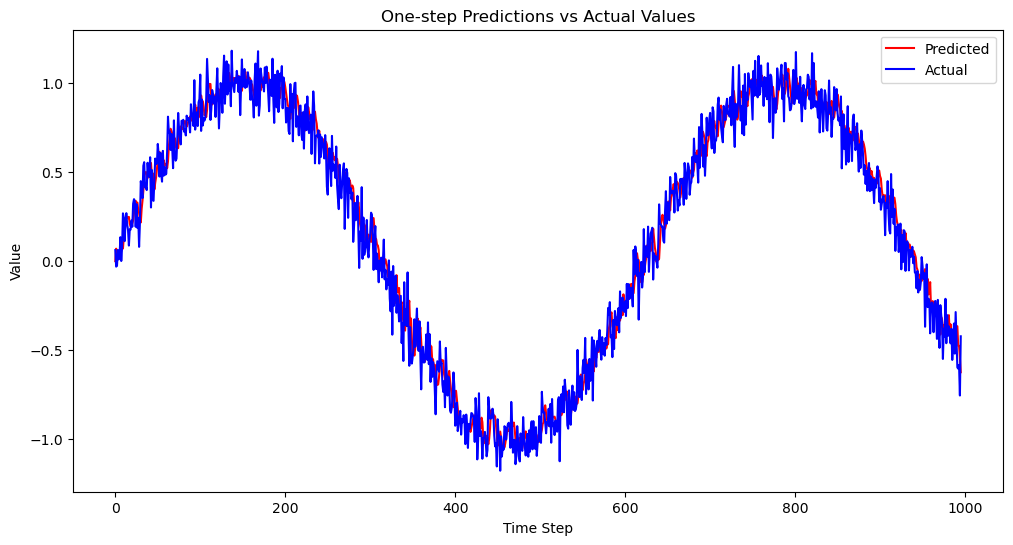

In [31]:
onestep_preds = net(features)
# 绘制预测值和真实值的对比图
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(onestep_preds.detach().numpy(), label='Predicted', color='red')
plt.plot(labels.detach().numpy(), label='Actual', color='blue')
plt.title('One-step Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


In [32]:
import collections
import re
import traintools

In [33]:
traintools.DATA_HUB['time_machine'] = (
	traintools.DATA_URL + 'timemachine.txt',
	'090b5e7e70c295757f55df93cb0a180b9691891a'
)

def read_time_machine():
    with open(traintools.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()

In [34]:
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])
print(lines[-1])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the
of man


In [35]:


tokens = traintools.tokenize(lines, 'word')

In [36]:
tokens

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells'],
 [],
 [],
 [],
 [],
 ['i'],
 [],
 [],
 ['the',
  'time',
  'traveller',
  'for',
  'so',
  'it',
  'will',
  'be',
  'convenient',
  'to',
  'speak',
  'of',
  'him'],
 ['was',
  'expounding',
  'a',
  'recondite',
  'matter',
  'to',
  'us',
  'his',
  'grey',
  'eyes',
  'shone',
  'and'],
 ['twinkled',
  'and',
  'his',
  'usually',
  'pale',
  'face',
  'was',
  'flushed',
  'and',
  'animated',
  'the'],
 ['fire',
  'burned',
  'brightly',
  'and',
  'the',
  'soft',
  'radiance',
  'of',
  'the',
  'incandescent'],
 ['lights',
  'in',
  'the',
  'lilies',
  'of',
  'silver',
  'caught',
  'the',
  'bubbles',
  'that',
  'flashed',
  'and'],
 ['passed',
  'in',
  'our',
  'glasses',
  'our',
  'chairs',
  'being',
  'his',
  'patents',
  'embraced',
  'and'],
 ['caressed',
  'us',
  'rather',
  'than',
  'submitted',
  'to',
  'be',
  'sat',
  'upon',
  'and',
  'there',
  'was',
  'that'],
 ['luxurious',
  'after',
  'dinner',

In [37]:
from numpy import sort


class Vocab:
	def __init__(self,tokens = None,min_freq =0,reserved_tokens=None):

		if tokens is None:
			tokens = []

		if reserved_tokens is None:
			reserved_tokens = []

		self._token_freqs = self.count_corpus(tokens)
		self._token_freqs = sorted(self.token_freqs.items(), key=lambda x: x[1], reverse=True)
		self.idx_to_token = ['<unk>'] + reserved_tokens
		self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
		for token,freq in self._token_freqs:
			if freq >= min_freq and token not in self.token_to_idx:
				self.idx_to_token.append(token)
				self.token_to_idx[token] = len(self.idx_to_token) - 1
			

	def __len__(self):
		return len(self.idx_to_token)
	
	def __getitem__(self, tokens):
		if not isinstance(tokens, (list, tuple)): 	# 如果是单个token
			return self.token_to_idx.get(tokens, self.unk)
		# 如果是多个token
		return [self.__getitem__(token) for token in tokens]

	def to_tokens(self, indices):
		if not isinstance(indices, (list, tuple)): # 如果是单个索引
			return self.idx_to_token[indices]
		# 如果是多个索引
		return [self.idx_to_token[idx] for idx in indices]

	@property
	def unk(self):
		return 0

	@property
	def token_freqs(self):
		return self._token_freqs

	def count_corpus(self,tokens):
		# 将tokens展平
		if len(tokens) == 0 or isinstance(tokens[0], list):
			tokens = [token for sublist in tokens for token in sublist]
		return collections.Counter(tokens)

In [38]:
vocab = Vocab(tokens)
print(f'词表大小: {len(vocab)}')
print(list(vocab.token_to_idx.items())[:10])  # 打印前10个词和对应的索引

for i in range(11):
    print(f'词: {tokens[i]}, 索引: {vocab[tokens[i]]}')

词表大小: 4580
[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]
词: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells'], 索引: [1, 19, 50, 40, 2183, 2184, 400]
词: [], 索引: []
词: [], 索引: []
词: [], 索引: []
词: [], 索引: []
词: ['i'], 索引: [2]
词: [], 索引: []
词: [], 索引: []
词: ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him'], 索引: [1, 19, 71, 16, 37, 11, 115, 42, 680, 6, 586, 4, 108]
词: ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and'], 索引: [7, 1420, 5, 2185, 587, 6, 126, 25, 330, 127, 439, 3]
词: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the'], 索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [39]:
import traintools
def load_time_machine(max_tokens = -1):
	lines = traintools.read_time_machine()
	tokens = traintools.tokenize(lines, 'char')
	vocab = traintools.Vocab(tokens)

	# 将所有token展平
	corpus = [token for sublist in tokens for token in sublist]

	if max_tokens > 0:
		corpus = corpus[:max_tokens]

	return corpus, vocab


In [40]:
corpus,vocab = load_time_machine()
print(len(corpus), len(vocab))

print(f'前10个字符: {corpus[:10]}')
print(f'前10个字符的索引: {[vocab[c] for c in corpus[:10]]}')

170580 28
前10个字符: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']
前10个字符的索引: [3, 9, 2, 1, 3, 5, 13, 2, 1, 13]


In [41]:
import random
import torch
import traintools

tokens = traintools.tokenize(traintools.read_time_machine())

corpus = [token for sublist in tokens for token in sublist]
len(corpus)

32775

In [42]:
vocab = traintools.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

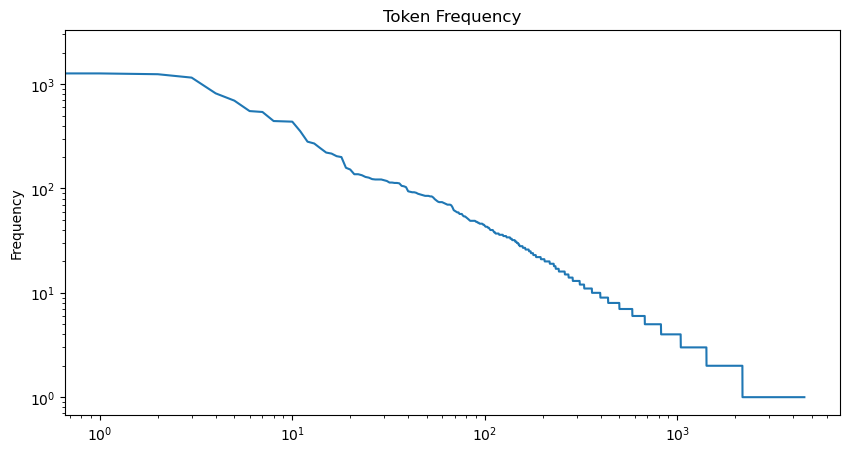

In [43]:
# 绘制词频图，x轴忽略，y轴按词频从大到小
def plot_token_frequency(vocab):
    token_freqs = vocab.token_freqs
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(token_freqs)), [freq for _, freq in token_freqs])
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Frequency')
    plt.title('Token Frequency')
    plt.show()

plot_token_frequency(vocab)

In [44]:
bigram_tokens = [pair for pair in zip(corpus[:-1],corpus[1:])]# 创建二元组
# corpus[:-1] 是从开始到倒数第二个元素的子列表
# corpus[1:] 是从第二个元素到最后的子列表
# 因此可以将相邻的两个词组成一个二元组
bigram_vocab = traintools.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [45]:
trigram_tokens = [triple for triple in zip(corpus[:-2],corpus[1:-1],corpus[2:])]# 创建三元组	
trigram_vocab = traintools.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

In [1]:
import traintools
my_seq = list(range(35))
for X,Y in traintools.seq_data_iter_random(my_seq,2,5):
    print(X,Y)

2025-08-21 00:59:31,200 - INFO - NumExpr defaulting to 16 threads.


tensor([[17, 18, 19, 20, 21],
        [ 7,  8,  9, 10, 11]]) tensor([[18, 19, 20, 21, 22],
        [ 8,  9, 10, 11, 12]])
tensor([[27, 28, 29, 30, 31],
        [22, 23, 24, 25, 26]]) tensor([[28, 29, 30, 31, 32],
        [23, 24, 25, 26, 27]])
tensor([[ 2,  3,  4,  5,  6],
        [12, 13, 14, 15, 16]]) tensor([[ 3,  4,  5,  6,  7],
        [13, 14, 15, 16, 17]])
